## Solving UMApHMP with VNS

In [1]:
import sys
from os import listdir
from os.path import isfile, join
import string

import numpy as np
from plot_utils import plot_two_solutions
import matplotlib.pyplot as plt 

from ioutils import parse_input
from ioutils import parse_solutions
from utils import get_distance_matrix
from utils import get_discount_matrix
from utils import allocate_paths
from utils import get_nodes
from utils import get_total_cost
from utils import get_flow_from_paths
import cplex_utils
import graph_utils as graph_utils

### Testing allocate_paths

In [2]:
DATASET = 'AP'
INPUT_DIRECTORY = "./data/AP/generated/"

In [3]:
files = [join(INPUT_DIRECTORY, f) for f in listdir(INPUT_DIRECTORY) if isfile(join(INPUT_DIRECTORY, f))]
print(files)
file = files[1]
print(file)

['./data/AP/generated/40.5', './data/AP/generated/10.3', './data/AP/generated/50.8', './data/AP/generated/25.8', './data/AP/generated/100.8', './data/AP/generated/200.8', './data/AP/generated/100.4', './data/AP/generated/20.8', './data/AP/generated/50.4', './data/AP/generated/15.4', './data/AP/generated/15.3', './data/AP/generated/20.3', './data/AP/generated/20.2', './data/AP/generated/40.8', './data/AP/generated/200.2', './data/AP/generated/10.8', './data/AP/generated/50.3', './data/AP/generated/200.5', './data/AP/generated/25.5', './data/AP/generated/10.2', './data/AP/generated/200.4', './data/AP/generated/50.2', './data/AP/generated/100.2', './data/AP/generated/40.2', './data/AP/generated/20.4', './data/AP/generated/40.4', './data/AP/generated/25.2', './data/AP/generated/50.5', './data/AP/generated/15.5', './data/AP/generated/25.3', './data/AP/generated/10.5', './data/AP/generated/100.3', './data/AP/generated/15.2', './data/AP/generated/200.3', './data/AP/generated/100.5', './data/A

In [4]:
n, p, alpha, delta, ksi, nodes_coordinates, demand = parse_input(file, DATASET)
nodes = get_nodes(n)
distances = get_distance_matrix(nodes_coordinates)

In [5]:
M, X, Y, Z, H = cplex_utils.get_umaphmp_model(n, p, alpha, delta, ksi, distances, demand, formulation='EK', verbose=True)
solution = M.solve(log_output=True)
hubs_bit_mask = [int(solution.get_var_value(H[i])) for i in range(n)]
cplex_objective = round(solution.objective_value, 7)

[2023-08-21 18:40:26,732] Created model M
[2023-08-21 18:40:26,757] Defined variables X
[2023-08-21 18:40:26,782] Defined variables Y
[2023-08-21 18:40:26,785] Defined variables Z
[2023-08-21 18:40:26,786] Defined variables H
[2023-08-21 18:40:26,787] Defined constraints (2)
[2023-08-21 18:40:26,789] Defined constraints (3)
[2023-08-21 18:40:26,797] Defined constraints (4)
[2023-08-21 18:40:26,813] Defined constraints (5)


[2023-08-21 18:40:26,830] Defined constraints (6)
[2023-08-21 18:40:26,847] Defined constraints (7)
[2023-08-21 18:40:26,863] Defined constraints (1)


Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 0 rows and 100 columns.
Reduced MIP has 411 rows, 2010 columns, and 5310 nonzeros.
Reduced MIP has 10 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (1.62 ticks)
Found incumbent of value 5.4035881e+08 after 0.01 sec. (3.81 ticks)
Probing time = 0.00 sec. (0.13 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 411 rows, 2010 columns, and 5310 nonzeros.
Reduced MIP has 10 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.04 ticks)
Probing time = 0.00 sec. (0.13 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.01 sec. (4.54 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integ

In [6]:
Z_allocated = {(i,k): solution.get_var_value(Z[i,k]) for i in range(n) for k in range(n)}
X_allocated = {(i,l,j): solution.get_var_value(X[i,l,j]) for i in range(n) for l in range(n) for j in range(n)}
Y_allocated = {(i,k,l): solution.get_var_value(Y[i,k,l]) for i in range(n) for k in range(n) for l in range(n)}
cplex_flow = cplex_utils.get_flow_from_XYZ(n, X_allocated, Y_allocated, Z_allocated)

In [7]:
hubs, = np.where(hubs_bit_mask)
hubs

array([2, 6, 7])

In [8]:
discounts = get_discount_matrix(n, hubs, alpha, delta, ksi)

In [9]:
paths = allocate_paths(n, hubs, distances, discounts)

In [10]:
vns_flow = get_flow_from_paths(n, paths, demand)

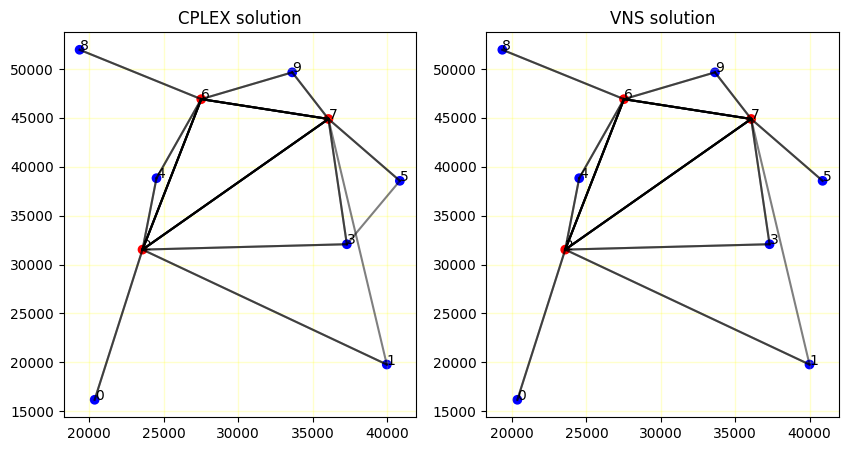

In [11]:
plot_two_solutions(nodes_coordinates, 
                   hubs_bit_mask, 
                   hubs_bit_mask, 
                   cplex_flow, 
                   vns_flow,  
                   title1="CPLEX solution",
                   title2="VNS solution",
                   point_labels='numbers', plot_all_lines=False, verbose=0)

In [12]:
# todo: AP/10.3: why cplex flow (graph on the left) contains non-hub - non-hub edge 3-5 ???
#   because we got some very small non-zero number => we should drop some decimals!
cplex_flow[5,3]

2.2737367544323206e-13

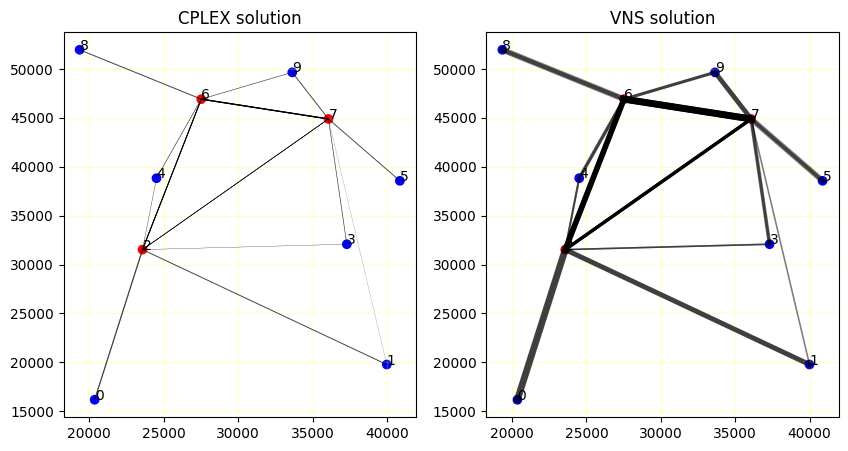

In [13]:
# if I choose that edge tickness represents flow (verbose=2) it's not visible
plot_two_solutions(nodes_coordinates, 
                   hubs_bit_mask, 
                   hubs_bit_mask, 
                   cplex_flow, 
                   vns_flow,  
                   title1="CPLEX solution",
                   title2="VNS solution",
                   point_labels='numbers', plot_all_lines=False, verbose=2)

In [14]:
get_total_cost(vns_flow, distances, discounts)

131581786.946515

In [15]:
get_total_cost(cplex_flow, distances, discounts)

131581786.94651498

In [16]:
cplex_objective

131581786.946515

### Implementing VNS algorithm framework

In [17]:
from vns import basic_VNS

from utils import ProblemInstance
from utils import Solution
from utils  import get_flow_from_hubs

In [18]:
MAX_ITER = 200

#### Testing

In [19]:
files = [join(INPUT_DIRECTORY, f) for f in listdir(INPUT_DIRECTORY) if isfile(join(INPUT_DIRECTORY, f))]
print(files)
file = files[1]
print(file)

['./data/AP/generated/40.5', './data/AP/generated/10.3', './data/AP/generated/50.8', './data/AP/generated/25.8', './data/AP/generated/100.8', './data/AP/generated/200.8', './data/AP/generated/100.4', './data/AP/generated/20.8', './data/AP/generated/50.4', './data/AP/generated/15.4', './data/AP/generated/15.3', './data/AP/generated/20.3', './data/AP/generated/20.2', './data/AP/generated/40.8', './data/AP/generated/200.2', './data/AP/generated/10.8', './data/AP/generated/50.3', './data/AP/generated/200.5', './data/AP/generated/25.5', './data/AP/generated/10.2', './data/AP/generated/200.4', './data/AP/generated/50.2', './data/AP/generated/100.2', './data/AP/generated/40.2', './data/AP/generated/20.4', './data/AP/generated/40.4', './data/AP/generated/25.2', './data/AP/generated/50.5', './data/AP/generated/15.5', './data/AP/generated/25.3', './data/AP/generated/10.5', './data/AP/generated/100.3', './data/AP/generated/15.2', './data/AP/generated/200.3', './data/AP/generated/100.5', './data/A

In [20]:
n, p, alpha, delta, ksi, node_coordinates, demand = parse_input(file, DATASET)
problem = ProblemInstance(n, p, alpha, delta, ksi, node_coordinates, demand)

In [21]:
vns_solution = basic_VNS(problem, use_c=False)

In [22]:
print(vns_solution.hubs)
print(vns_solution.cost)

[6, 2, 7]
131581786.94651498


In [23]:
flow = get_flow_from_hubs(
    vns_solution.hubs, 
    problem.n, 
    problem.alpha, 
    problem.delta, 
    problem.ksi, 
    problem.distances, 
    problem.demand)

In [24]:
from plot_utils import plot_solution
from utils import bitmap

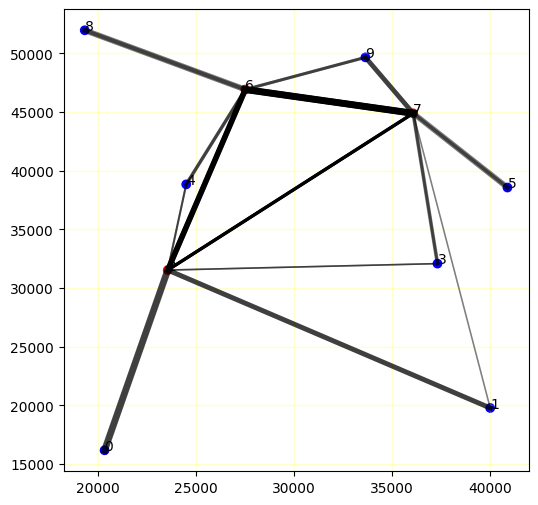

In [25]:
plot_solution(node_coordinates, bitmap(n, vns_solution.hubs), flow, point_labels='numbers', plot_all_lines=False, verbose=2)

#### Display comparison with state of the art

In [26]:
from utils import get_comparison_table
from ioutils import get_comparison_table_file_name
from utils import get_latest_commit_id

import pandas as pd
pd.set_option('display.max_rows', 500)

In [27]:
SOLUTIONS_FILE = '/home/ubuntu/VNS_for_UMApHMP/data/AP/Solutions-UMApHMP.txt'
NUMBER_OF_PROBLEMS = 0
LATEST_COMMIT_ID = get_latest_commit_id()
OUTPUT_FILE_NAME = get_comparison_table_file_name('comparison_with_optimal', str(NUMBER_OF_PROBLEMS), LATEST_COMMIT_ID)

In [28]:
comparison_table = get_comparison_table([basic_VNS], NUMBER_OF_PROBLEMS, DATASET, INPUT_DIRECTORY, SOLUTIONS_FILE)
comparison_table.to_csv(OUTPUT_FILE_NAME, index_label='problem')

0it [00:00, ?it/s]


In [29]:
comparison_table.head(NUMBER_OF_PROBLEMS)

,optimal solution,basic_VNS - solution,basic_VNS - deviation (%),basic_VNS - time (s)


### Experimentation

#### 1. Shaking intensity

In [30]:
NUMBER_OF_PROBLEMS = 0
OUTPUT_FILE_NAME = get_comparison_table_file_name('diversification', str(NUMBER_OF_PROBLEMS), LATEST_COMMIT_ID)

In [31]:
def basic_VNS_divers_0_1(problem):
    return basic_VNS(problem, 0.1)

def basic_VNS_divers_0_2(problem):
    return basic_VNS(problem, 0.2)

def basic_VNS_divers_0_5(problem):
    return basic_VNS(problem, 0.5)

def basic_VNS_divers_1(problem):
    return basic_VNS(problem, 1)

In [32]:
comparison_table = get_comparison_table(
    [basic_VNS, basic_VNS_divers_0_1, basic_VNS_divers_0_2, basic_VNS_divers_0_5, basic_VNS_divers_1], 
    NUMBER_OF_PROBLEMS, DATASET, INPUT_DIRECTORY, SOLUTIONS_FILE)

0it [00:00, ?it/s]


In [33]:
comparison_table.head(NUMBER_OF_PROBLEMS)

,optimal solution,basic_VNS - solution,basic_VNS - deviation (%),basic_VNS - time (s),basic_VNS_divers_0_1 - solution,basic_VNS_divers_0_1 - deviation (%),basic_VNS_divers_0_1 - time (s),basic_VNS_divers_0_2 - solution,basic_VNS_divers_0_2 - deviation (%),basic_VNS_divers_0_2 - time (s),basic_VNS_divers_0_5 - solution,basic_VNS_divers_0_5 - deviation (%),basic_VNS_divers_0_5 - time (s),basic_VNS_divers_1 - solution,basic_VNS_divers_1 - deviation (%),basic_VNS_divers_1 - time (s)


In [34]:
comparison_table.to_csv(OUTPUT_FILE_NAME, index_label='problem')

#### 2. Initial solution

In [35]:
from vns import get_initial_solution_median
from vns import get_initial_solution_robust

In [36]:
NUMBER_OF_PROBLEMS = 0
OUTPUT_FILE_NAME = get_comparison_table_file_name('initial_solution', str(NUMBER_OF_PROBLEMS), LATEST_COMMIT_ID)

In [37]:
def basic_VNS_median_init(problem):
    return basic_VNS(problem, initialization_method=get_initial_solution_median)

def basic_VNS_robust_init(problem):
    return basic_VNS(problem, initialization_method=get_initial_solution_robust)

In [38]:
comparison_table = get_comparison_table(
    [basic_VNS_robust_init, basic_VNS_median_init], 
    NUMBER_OF_PROBLEMS, DATASET, INPUT_DIRECTORY, SOLUTIONS_FILE)

0it [00:00, ?it/s]


In [39]:
comparison_table.head(NUMBER_OF_PROBLEMS)

,optimal solution,basic_VNS_robust_init - solution,basic_VNS_robust_init - deviation (%),basic_VNS_robust_init - time (s),basic_VNS_median_init - solution,basic_VNS_median_init - deviation (%),basic_VNS_median_init - time (s)


In [40]:
comparison_table.to_csv(OUTPUT_FILE_NAME, index_label='problem')

#### 3. Local search

In [41]:
from vns import local_search_best_improvement
from vns import local_search_first_improvement

In [42]:
NUMBER_OF_PROBLEMS = 0
OUTPUT_FILE_NAME = get_comparison_table_file_name('local_search', str(NUMBER_OF_PROBLEMS), LATEST_COMMIT_ID)

In [43]:
def basic_VNS_best_improvement(problem):
    return basic_VNS(problem, local_search=local_search_best_improvement)

def basic_VNS_first_improvement(problem):
    return basic_VNS(problem, local_search=local_search_first_improvement)

In [44]:
comparison_table = get_comparison_table(
    [basic_VNS_best_improvement, basic_VNS_first_improvement], 
    NUMBER_OF_PROBLEMS, DATASET, INPUT_DIRECTORY, SOLUTIONS_FILE)

0it [00:00, ?it/s]


In [45]:
comparison_table.head(NUMBER_OF_PROBLEMS)

,optimal solution,basic_VNS_best_improvement - solution,basic_VNS_best_improvement - deviation (%),basic_VNS_best_improvement - time (s),basic_VNS_first_improvement - solution,basic_VNS_first_improvement - deviation (%),basic_VNS_first_improvement - time (s)


In [46]:
comparison_table.to_csv(OUTPUT_FILE_NAME, index_label='problem')

This looks like very nice eifficiency imrpovement!
Now we need to adjust MAX_ITER, since some solutions are not optimal in 25 iterations. 

#### 4. Implement the most critical parts in C

We moved `get_solution_cost` into C.

In [47]:
NUMBER_OF_PROBLEMS = 25
OUTPUT_FILE_NAME = get_comparison_table_file_name('using_c', str(NUMBER_OF_PROBLEMS), LATEST_COMMIT_ID)

In [48]:
def basic_VNS_with_parts_in_C(problem):
    return basic_VNS(problem, use_c=True)

In [49]:
comparison_table = get_comparison_table(
    [basic_VNS, basic_VNS_with_parts_in_C], 
    NUMBER_OF_PROBLEMS, DATASET, INPUT_DIRECTORY, SOLUTIONS_FILE)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [03:57<00:00,  9.51s/it]


In [50]:
comparison_table.head(NUMBER_OF_PROBLEMS)

,optimal solution,basic_VNS - solution,basic_VNS - deviation (%),basic_VNS - time (s),basic_VNS_with_parts_in_C - solution,basic_VNS_with_parts_in_C - deviation (%),basic_VNS_with_parts_in_C - time (s)
10.2,163603.94,163603.943168,0.0,0.239806,163603.939352,0.0,0.018323
10.3,131581.79,131581.786947,0.0,0.310190,131581.782695,0.0,0.025893
10.4,107354.73,107354.729873,0.0,0.361431,107354.726587,0.0,0.031411
10.5,86028.88,86028.884330,0.0,0.352441,86028.881876,0.0,0.033858
10.8,NaN,54628.751330,NaN,0.204286,54628.749570,NaN,0.021793
15.2,NaN,167236.841808,NaN,0.770828,167236.836181,NaN,0.043816
15.3,NaN,147872.074743,NaN,1.117670,147872.069114,NaN,0.064671
15.4,NaN,128607.690962,NaN,1.376814,128607.684728,NaN,0.081286
15.5,NaN,111464.727152,NaN,1.552482,111464.721588,NaN,0.094213
15.8,NaN,78050.108362,NaN,1.775334,78050.103986,NaN,0.114408


In [51]:
comparison_table.to_csv(OUTPUT_FILE_NAME, index_label='problem')

#### 5. Try 3 neighbourhoods for shaking

In [52]:
NUMBER_OF_PROBLEMS = 0
OUTPUT_FILE_NAME = get_comparison_table_file_name('3_neighbourhoods', str(NUMBER_OF_PROBLEMS), LATEST_COMMIT_ID)

In [53]:
from utils import NEIGHBOURHOOD_TYPES

In [54]:
def basic_VNS_with_3_neighbourhoods(problem):
    return basic_VNS(problem, neighbourhood_types=NEIGHBOURHOOD_TYPES)

In [55]:
comparison_table = get_comparison_table(
    [basic_VNS, basic_VNS_with_3_neighbourhoods], 
    NUMBER_OF_PROBLEMS, DATASET, INPUT_DIRECTORY, SOLUTIONS_FILE)

0it [00:00, ?it/s]


In [56]:
comparison_table.head(NUMBER_OF_PROBLEMS)

,optimal solution,basic_VNS - solution,basic_VNS - deviation (%),basic_VNS - time (s),basic_VNS_with_3_neighbourhoods - solution,basic_VNS_with_3_neighbourhoods - deviation (%),basic_VNS_with_3_neighbourhoods - time (s)


In [57]:
comparison_table.to_csv(OUTPUT_FILE_NAME, index_label='problem')